## Setup environment



## Setup imports

In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from torch.nn import MSELoss
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from make_data_utils import MakeLesionMaskedDatad
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
)
from monai.utils import set_determinism

import torch

print_config()


/opt/conda/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
scipy version: 1.11.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+rocm5.4.2
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.30.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional 

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "/deneb_disk/monai_data"

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/deneb_disk/monai_data


## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)


## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [6]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        MakeLesionMaskedDatad(keys=["image", "label"]),
        # EnsureChannelFirstd(keys=["image","label"]),
        #Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(1.0, 1.0, 1.0),
        #    mode=("bilinear", "bilinear"),
        #),
        Resized(keys=["image", "label"], spatial_size=(64, 64, 64), mode=["bilinear", "bilinear"]),
        #RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys=["image","label"], nonzero=False, channel_wise=True),

        #RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        #RandShiftIntensityd(keys=["image", "label"], offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        #Resized(keys=["image", "label"], spatial_size=(64, 64, 64), mode=["bilinear", "bilinear"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        MakeLesionMaskedDatad(keys=["image", "label"]),
        # EnsureChannelFirstd(keys=["image","label"]),
        #Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(1.0, 1.0, 1.0),
        #    mode=("bilinear", "nearest"),
        #),
        Resized(keys=["image", "label"], spatial_size=(64, 64, 64), mode=["bilinear", "bilinear"]),
        NormalizeIntensityd(keys=["image", "label"], nonzero=False, channel_wise=True),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [7]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)


2023-11-01 06:59:57,197 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-11-01 06:59:57,199 - INFO - File exists: /deneb_disk/monai_data/Task01_BrainTumour.tar, skipped downloading.
2023-11-01 06:59:57,201 - INFO - Non-empty folder exists in /deneb_disk/monai_data/Task01_BrainTumour, skipped extracting.


## Check data shape and visualize

image shape: torch.Size([1, 64, 64, 64])


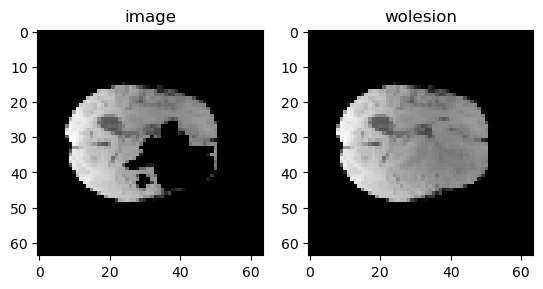

In [8]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[0]
SL = int(val_data_example["image"].shape[3]/2)
print(f"image shape: {val_data_example['image'].shape}")

plt.figure()
plt.subplot(1, 2, 1)
plt.title(f"image")
plt.imshow(val_data_example["image"][0, :, :, SL].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"wolesion")
plt.imshow(val_data_example["label"][0, :, :, SL].detach().cpu(), cmap="gray")
plt.show()


In [9]:
print(SL)

32


## Create Model, Loss, Optimizer

In [10]:
max_epochs = 100
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    channels=[8,16, 32,32, 16,8],
    strides=[2, 2, 2, 2, 2,2,2],
    in_channels=1,
    out_channels=1,
).to(device)
loss_function = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(64,64,64),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

/opt/conda/lib/python3.11/site-packages/monai/networks/nets/unet.py:133: UserWarning: `len(strides) > len(channels) - 1`, the last 2 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


In [11]:
len(val_ds)

96

## Execute a typical PyTorch training process

In [ ]:
best_metric = 1e6
best_metric_epoch = 1e6
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_ds:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        print(f'input shape: {inputs.shape}')
        with torch.cuda.amp.autocast():
            outputs = model(inputs[None, ...])
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )

        #model.eval()
        #with torch.no_grad():
        #    for val_data in val_ds:
        #        val_inputs, val_labels = (
        #            val_data["image"].to(device),
        #            val_data["label"].to(device),
        #        )
        #        val_outputs = inference(val_inputs[None,...])
 

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch+1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric = 0.0
            for val_data in val_ds:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                #print(val_inputs.shape)
                val_outputs = inference(val_inputs[None,...])
                #val_outputs = [post_trans(i)
                #               for i in decollate_batch(val_outputs)]
                loss = loss_function(val_outputs, val_labels)
                metric += loss.item()
            
            metric /= len(val_ds)
            
            metric_values.append(metric)
            #metric_batch = dice_metric_batch.aggregate()
            #metric_tc = metric_batch[0].item()
            #metric_values_tc.append(metric_tc)
            # metric_wt = metric_batch[1].item()
            # metric_values_wt.append(metric_wt)
            # metric_et = metric_batch[2].item()
            # metric_values_et.append(metric_et)
            #metric.reset()
            #dice_metric_batch.reset()

            torch.save(model.state_dict(), os.path.join(
                root_dir, "latest_model.pth"))

            if metric < best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(
                    time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mse: {metric:.4f}"
                f" tc: {metric:.4f}"
                f"\nbest mse: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(
        f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


In [12]:
print(
    f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}."
)

NameError: name 'best_metric' is not defined

## Plot the loss and metric

NameError: name 'epoch_loss_values' is not defined

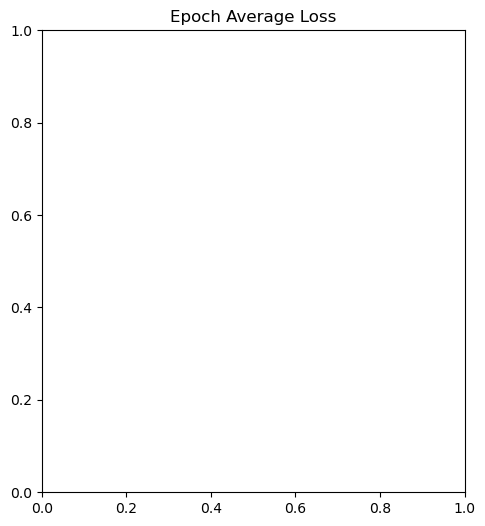

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()


## Check best model output with the input image and label

In [14]:
val_output.shape

NameError: name 'val_output' is not defined

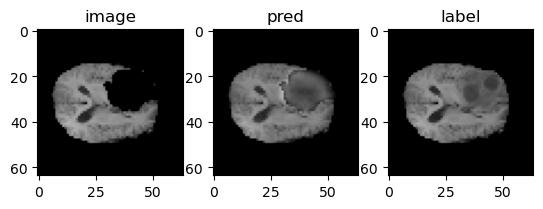

In [41]:
num=1
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[num]["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = val_output[0]
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_input[0,0, :, :, 32].detach().cpu(), cmap="gray",vmin=0,vmax=5)
    #plt.show()
    plt.subplot(1, 3, 2)
    plt.title(f"pred")
    plt.imshow(val_output[0, :, :, 32].detach().cpu(), cmap="gray",vmin=0,vmax=5)
    plt.subplot(1, 3, 3)
    plt.title(f"label")
    plt.imshow(val_ds[num]["label"][0, :, :, 32].detach().cpu(), cmap="gray",vmin=0,vmax=5)
    plt.show()


## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(
    val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    metric = 0.0
    for val_data in val_ds: # val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs[None,...])
        #val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        loss = loss_function(val_outputs.to(device), val_labels.to(device))
        metric += loss.item()
            
    metric /= len(val_ds)

print(f"metric: {metric:.4f}")


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)
